# BGA two-stage models (201+58 AISNP + extra AISNPs)

This notebook trains ancestry inference models in two stages:


1. **Stage 1 – Continental (super-pop)**: AFR / AMR / EAS / EUR / SAS.

2. **Stage 2 – Population (grouped labels inside each continent)**.


Input data: `data/merged_matrix_201plus58_with_new_samples.csv` (baseline 201+58 SNPs + extra AISNP SNPs, same 1kGP samples).

Outputs are saved under `models/` as pickled artifacts for later inference.

In [2]:
import os

import numpy as np
import pandas as pd

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from xgboost import XGBClassifier

from src.generative_model import GenerativeBGAModel

DATA_PATH = "data/merged_matrix_201plus58_with_new_samples.csv"
MODELS_DIR = "models"
os.makedirs(MODELS_DIR, exist_ok=True)

print("Using data:", DATA_PATH)


Using data: data/merged_matrix_201plus58_with_new_samples.csv


In [3]:
# Load data and basic checks

df = pd.read_csv(DATA_PATH)
print("Shape:", df.shape)
print("Columns:", df.columns[:10], "...")
print("Super pops:", df["super_pop"].value_counts().to_dict())
print("Pops:", df["pop"].value_counts().to_dict())

meta_cols = ["sample", "pop", "super_pop"]
feature_cols = [c for c in df.columns if c not in meta_cols]

X = df[feature_cols].values
y_super = df["super_pop"].values

imputer = SimpleImputer(strategy="median")
X_imputed = imputer.fit_transform(X)

le_super = LabelEncoder()
y_super_enc = le_super.fit_transform(y_super)

print("Features:", len(feature_cols))


Shape: (2347, 299)
Columns: Index(['sample', 'pop', 'super_pop', 'rs2814778', 'rs11184898', 'rs12119914',
       'rs3917750', 'rs11264001', 'rs2759281', 'rs9442234'],
      dtype='object') ...
Super pops: {'EAS': 504, 'AFR': 504, 'EUR': 503, 'SAS': 489, 'AMR': 347}
Pops: {'GWD': 113, 'YRI': 108, 'IBS': 107, 'TSI': 107, 'CHS': 105, 'JPT': 104, 'PUR': 104, 'CHB': 103, 'GIH': 103, 'STU': 102, 'ITU': 102, 'KHV': 99, 'FIN': 99, 'CEU': 99, 'LWK': 99, 'ESN': 99, 'PJL': 96, 'CLM': 94, 'CDX': 93, 'GBR': 91, 'BEB': 86, 'PEL': 85, 'MSL': 85, 'MXL': 64}
Features: 296


In [4]:
# Stage 1: Continental classification (super_pop)

X_train, X_test, y_train, y_test = train_test_split(
    X_imputed,
    y_super_enc,
    test_size=0.2,
    random_state=42,
    stratify=y_super_enc,
)

print("Train size:", X_train.shape[0], "Test size:", X_test.shape[0])

xgb_continental = XGBClassifier(
    n_estimators=400,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    objective="multi:softprob",
    eval_metric="mlogloss",
    n_jobs=-1,
    random_state=42,
)

xgb_continental.fit(X_train, y_train)

y_pred_xgb = xgb_continental.predict(X_test)
acc_xgb = accuracy_score(y_test, y_pred_xgb)
print("[Stage 1] XGB accuracy:", acc_xgb)
report_xgb = classification_report(y_test, y_pred_xgb, target_names=le_super.classes_, output_dict=True)
print(classification_report(y_test, y_pred_xgb, target_names=le_super.classes_))

gen_continental = GenerativeBGAModel()
gen_continental.fit(X_train, y_train, snp_names=feature_cols)

y_pred_gen = gen_continental.predict(X_test)
acc_gen = accuracy_score(y_test, y_pred_gen)
print("[Stage 1] Generative accuracy:", acc_gen)
report_gen = classification_report(y_test, y_pred_gen, target_names=le_super.classes_, output_dict=True)
print(classification_report(y_test, y_pred_gen, target_names=le_super.classes_))

# Confusion matrices for Stage 1 (for plotting)
cm_xgb = confusion_matrix(y_test, y_pred_xgb, labels=np.arange(len(le_super.classes_)))
cm_gen = confusion_matrix(y_test, y_pred_gen, labels=np.arange(len(le_super.classes_)))

stage1_results = {
    "classes": list(le_super.classes_),
    "cm_xgb": cm_xgb,
    "cm_gen": cm_gen,
    "acc_xgb": float(acc_xgb),
    "acc_gen": float(acc_gen),
}

stage1_metrics = {
    "XGB": {
        "accuracy": float(acc_xgb),
        "macro_f1": float(report_xgb["macro avg"]["f1-score"]),
        "weighted_f1": float(report_xgb["weighted avg"]["f1-score"]),
    },
    "Generative": {
        "accuracy": float(acc_gen),
        "macro_f1": float(report_gen["macro avg"]["f1-score"]),
        "weighted_f1": float(report_gen["weighted avg"]["f1-score"]),
    },
}

# Refit both models on full data for saving
xgb_continental.fit(X_imputed, y_super_enc)
gen_continental.fit(X_imputed, y_super_enc, snp_names=feature_cols)

import pickle

continental_artifacts = {
    "imputer": imputer,
    "label_encoder": le_super,
    "snp_names": feature_cols,
    "xgb_model": xgb_continental,
    "gen_model": gen_continental,
}

with open(os.path.join(MODELS_DIR, "continental_artifacts.pkl"), "wb") as f:
    pickle.dump(continental_artifacts, f)

print("Saved continental artifacts to", os.path.join(MODELS_DIR, "continental_artifacts.pkl"))


Train size: 1877 Test size: 470
[Stage 1] XGB accuracy: 0.9787234042553191
              precision    recall  f1-score   support

         AFR       1.00      1.00      1.00       101
         AMR       0.97      0.88      0.92        69
         EAS       1.00      1.00      1.00       101
         EUR       0.93      0.99      0.96       101
         SAS       1.00      0.99      0.99        98

    accuracy                           0.98       470
   macro avg       0.98      0.97      0.98       470
weighted avg       0.98      0.98      0.98       470

[Stage 1] Generative accuracy: 0.9787234042553191
              precision    recall  f1-score   support

         AFR       1.00      1.00      1.00       101
         AMR       1.00      0.86      0.92        69
         EAS       1.00      1.00      1.00       101
         EUR       0.91      1.00      0.95       101
         SAS       1.00      1.00      1.00        98

    accuracy                           0.98       470
   mac

c:\Users\Admin\Uni\lc0_project\BGA-AISNP\src\generative_model.py:122: RuntimeWarning: divide by zero encountered in log
  log_post[i] = np.log(probs)


Saved continental artifacts to models\continental_artifacts.pkl


In [5]:
# Define population grouping per continent

afr_group_map = {
    "ESN": "ESNGWD",
    "GWD": "ESNGWD",
    "LWK": "LWKMSL",
    "MSL": "LWKMSL",
    "YRI": "YRI",
}

amr_group_map = {
    "CLM": "CLMMXL",
    "MXL": "CLMMXL",
    "PEL": "PEL",
    "PUR": "PUR",
}

eas_group_map = {
    "CHB": "CHBCHS",
    "CHS": "CHBCHS",
    "CDX": "CDXKHV",
    "KHV": "CDXKHV",
    "JPT": "JPT",
}

eur_group_map = {
    "CEU": "CEUGBR",
    "GBR": "CEUGBR",
    "IBS": "IBSTSI",
    "TSI": "IBSTSI",
    "FIN": "FIN",
}

sas_group_map = {
    "BEB": "BEBGIH",
    "GIH": "BEBGIH",
    "ITU": "ITUPJL",
    "PJL": "ITUPJL",
    "STU": "STU",
}

continent_group_maps = {
    "AFR": afr_group_map,
    "AMR": amr_group_map,
    "EAS": eas_group_map,
    "EUR": eur_group_map,
    "SAS": sas_group_map,
}

print("Defined grouping maps for continents:", list(continent_group_maps.keys()))


Defined grouping maps for continents: ['AFR', 'AMR', 'EAS', 'EUR', 'SAS']


In [6]:
# Stage 2: grouped population models per continent

population_models = {}
stage2_results = []
stage2_confusions = {}
stage2_metrics = []

for continent in sorted(df["super_pop"].unique()):
    df_c = df[df["super_pop"] == continent].copy()
    X_c = df_c[feature_cols].values
    X_c_imp = imputer.transform(X_c)

    y_pop = df_c["pop"].values
    group_map = continent_group_maps.get(continent, {})
    y_group = np.array([group_map.get(p, p) for p in y_pop])

    le_group = LabelEncoder()
    y_group_enc = le_group.fit_transform(y_group)

    X_tr, X_te, y_tr, y_te = train_test_split(
        X_c_imp,
        y_group_enc,
        test_size=0.2,
        random_state=42,
        stratify=y_group_enc,
    )

    xgb_pop = XGBClassifier(
        n_estimators=400,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.9,
        colsample_bytree=0.9,
        objective="multi:softprob",
        eval_metric="mlogloss",
        n_jobs=-1,
        random_state=42,
    )

    xgb_pop.fit(X_tr, y_tr)
    y_pred_xgb = xgb_pop.predict(X_te)
    acc_xgb = accuracy_score(y_te, y_pred_xgb)

    gen_pop = GenerativeBGAModel()
    gen_pop.fit(X_tr, y_tr, snp_names=feature_cols)
    y_pred_gen = gen_pop.predict(X_te)
    acc_gen = accuracy_score(y_te, y_pred_gen)

    print(f"\n[Stage 2] {continent}: XGB acc={acc_xgb:.4f}, Gen acc={acc_gen:.4f}")
    print("Classes (grouped):", list(le_group.classes_))

    # Metrics (accuracy + macro/weighted F1) for LaTeX tables
    rep_xgb_c = classification_report(y_te, y_pred_xgb, target_names=le_group.classes_, output_dict=True)
    rep_gen_c = classification_report(y_te, y_pred_gen, target_names=le_group.classes_, output_dict=True)

    stage2_metrics.append({
        "continent": continent,
        "model": "XGB",
        "accuracy": float(acc_xgb),
        "macro_f1": float(rep_xgb_c["macro avg"]["f1-score"]),
        "weighted_f1": float(rep_xgb_c["weighted avg"]["f1-score"]),
    })
    stage2_metrics.append({
        "continent": continent,
        "model": "Generative",
        "accuracy": float(acc_gen),
        "macro_f1": float(rep_gen_c["macro avg"]["f1-score"]),
        "weighted_f1": float(rep_gen_c["weighted avg"]["f1-score"]),
    })

    # Lưu kết quả tổng quan cho vẽ biểu đồ
    stage2_results.append({"continent": continent, "model": "XGB", "accuracy": float(acc_xgb)})
    stage2_results.append({"continent": continent, "model": "Generative", "accuracy": float(acc_gen)})

    # Confusion matrices cho từng châu lục
    cm_xgb_c = confusion_matrix(y_te, y_pred_xgb, labels=np.arange(len(le_group.classes_)))
    cm_gen_c = confusion_matrix(y_te, y_pred_gen, labels=np.arange(len(le_group.classes_)))
    stage2_confusions[continent] = {
        "classes": list(le_group.classes_),
        "cm_xgb": cm_xgb_c,
        "cm_gen": cm_gen_c,
    }

    # Refit on all data for this continent
    xgb_pop.fit(X_c_imp, y_group_enc)
    gen_pop.fit(X_c_imp, y_group_enc, snp_names=feature_cols)

    population_models[continent] = {
        "label_encoder": le_group,
        "xgb_model": xgb_pop,
        "gen_model": gen_pop,
    }

import pickle

pop_models_path = os.path.join(MODELS_DIR, "population_models_grouped.pkl")
with open(pop_models_path, "wb") as f:
    pickle.dump(population_models, f)

print("Saved grouped population models to", pop_models_path)



[Stage 2] AFR: XGB acc=0.6535, Gen acc=0.6535
Classes (grouped): [np.str_('ESNGWD'), np.str_('LWKMSL'), np.str_('YRI')]

[Stage 2] AMR: XGB acc=0.6714, Gen acc=0.7857
Classes (grouped): [np.str_('CLMMXL'), np.str_('PEL'), np.str_('PUR')]

[Stage 2] EAS: XGB acc=0.9307, Gen acc=0.9505
Classes (grouped): [np.str_('CDXKHV'), np.str_('CHBCHS'), np.str_('JPT')]

[Stage 2] EUR: XGB acc=0.8119, Gen acc=0.8713
Classes (grouped): [np.str_('CEUGBR'), np.str_('FIN'), np.str_('IBSTSI')]

[Stage 2] SAS: XGB acc=0.4796, Gen acc=0.5816
Classes (grouped): [np.str_('BEBGIH'), np.str_('ITUPJL'), np.str_('STU')]
Saved grouped population models to models\population_models_grouped.pkl


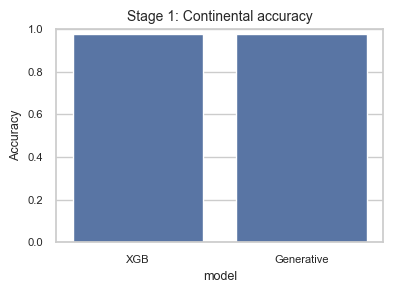

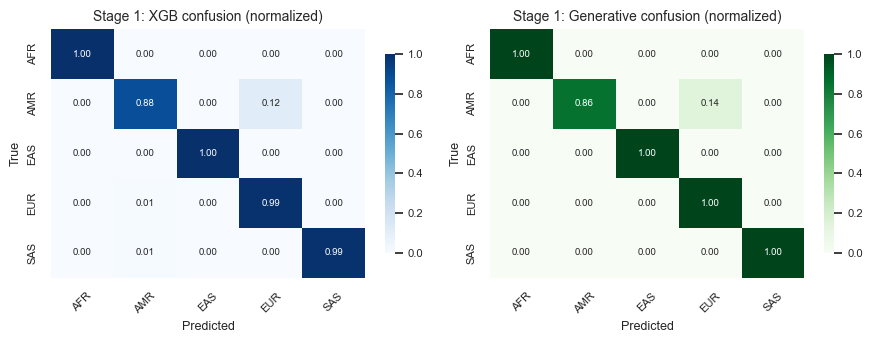

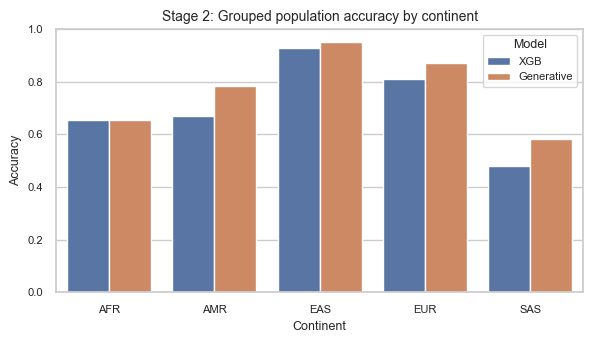

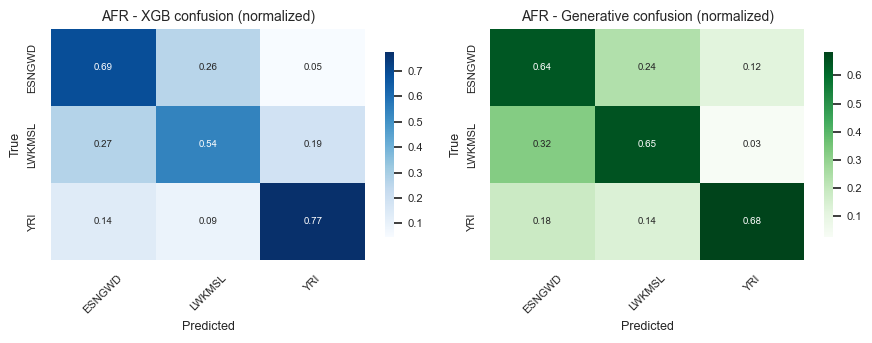

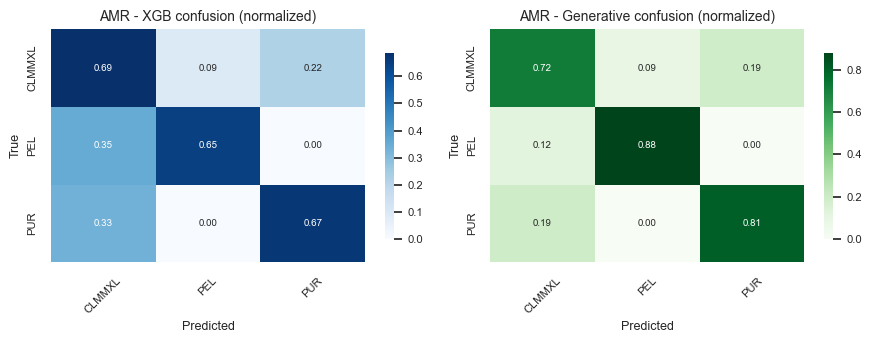

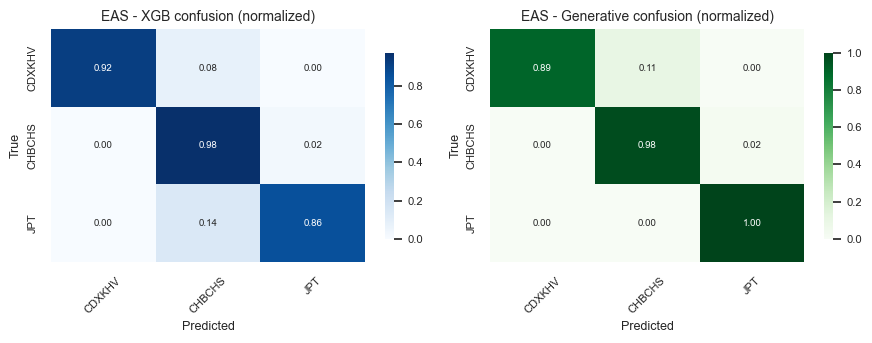

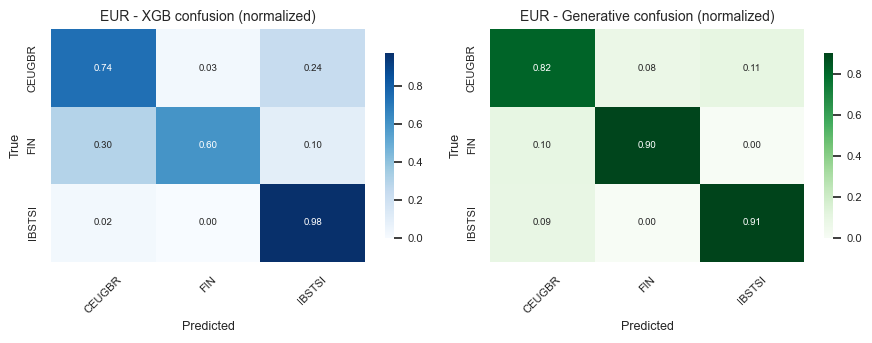

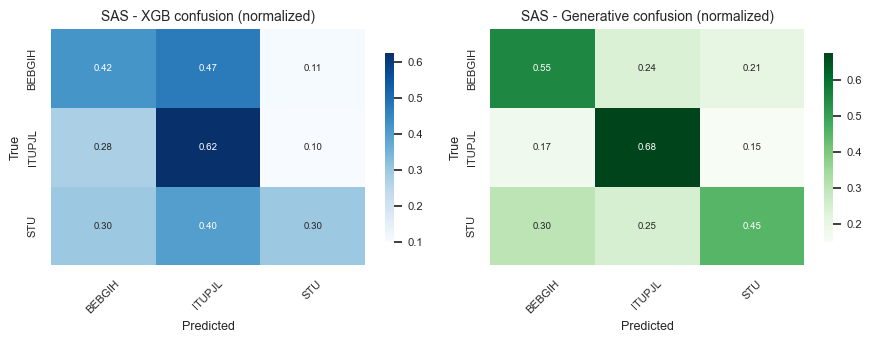

Saved filtered Stage 1 SNP importance to models\snp_importance\stage1_snp_importance_filtered.csv (n=57)
Saved filtered Stage 2 SNP importance for AFR to models\snp_importance\stage2_snp_importance_AFR.csv (n=219)
Saved filtered Stage 2 SNP importance for AMR to models\snp_importance\stage2_snp_importance_AMR.csv (n=228)
Saved filtered Stage 2 SNP importance for EAS to models\snp_importance\stage2_snp_importance_EAS.csv (n=165)
Saved filtered Stage 2 SNP importance for EUR to models\snp_importance\stage2_snp_importance_EUR.csv (n=232)
Saved filtered Stage 2 SNP importance for SAS to models\snp_importance\stage2_snp_importance_SAS.csv (n=267)


In [7]:
# Plots: Stage 1 and Stage 2 accuracies + confusion matrices; save SNP importance tables

import matplotlib.pyplot as plt
import seaborn as sns

# Smaller, cleaner style for plots
sns.set(style="whitegrid", context="notebook")
plt.rcParams.update({
    "font.size": 9,
    "axes.titlesize": 10,
    "axes.labelsize": 9,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
})

# --- Stage 1: continental accuracy (bar) ---
fig, ax = plt.subplots(figsize=(4, 3))
stage1_df = pd.DataFrame({
    "model": ["XGB", "Generative"],
    "accuracy": [float(stage1_results["acc_xgb"]), float(stage1_results["acc_gen"])],
})
sns.barplot(data=stage1_df, x="model", y="accuracy", ax=ax)
ax.set_ylim(0.0, 1.0)
ax.set_ylabel("Accuracy")
ax.set_title("Stage 1: Continental accuracy")
fig.tight_layout()
plt.show()

# --- Stage 1: confusion matrices (normalized) ---
classes1 = stage1_results["classes"]
cm_xgb_1 = stage1_results["cm_xgb"]
cm_gen_1 = stage1_results["cm_gen"]

cm_xgb_norm = cm_xgb_1.astype(float) / np.maximum(cm_xgb_1.sum(axis=1, keepdims=True), 1)
cm_gen_norm = cm_gen_1.astype(float) / np.maximum(cm_gen_1.sum(axis=1, keepdims=True), 1)

fig, axes = plt.subplots(1, 2, figsize=(9, 3.5))
sns.heatmap(cm_xgb_norm, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=classes1, yticklabels=classes1, ax=axes[0],
            cbar_kws={"shrink": 0.8}, annot_kws={"size": 7})
axes[0].set_title("Stage 1: XGB confusion (normalized)")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("True")
axes[0].tick_params(axis="x", rotation=45)

sns.heatmap(cm_gen_norm, annot=True, fmt=".2f", cmap="Greens",
            xticklabels=classes1, yticklabels=classes1, ax=axes[1],
            cbar_kws={"shrink": 0.8}, annot_kws={"size": 7})
axes[1].set_title("Stage 1: Generative confusion (normalized)")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("True")
axes[1].tick_params(axis="x", rotation=45)
fig.tight_layout()
plt.show()

# --- Stage 2: grouped population accuracy by continent (bar) ---
stage2_df = pd.DataFrame(stage2_results)
fig, ax = plt.subplots(figsize=(6, 3.5))
sns.barplot(data=stage2_df, x="continent", y="accuracy", hue="model", ax=ax)
ax.set_ylim(0.0, 1.0)
ax.set_ylabel("Accuracy")
ax.set_xlabel("Continent")
ax.set_title("Stage 2: Grouped population accuracy by continent")
ax.legend(title="Model", fontsize=8, title_fontsize=9)
fig.tight_layout()
plt.show()

# --- Stage 2: confusion matrices per continent (normalized) ---
for continent, info in stage2_confusions.items():
    classes_c = info["classes"]
    cm_xgb_c = info["cm_xgb"]
    cm_gen_c = info["cm_gen"]
    cm_xgb_norm_c = cm_xgb_c.astype(float) / np.maximum(cm_xgb_c.sum(axis=1, keepdims=True), 1)
    cm_gen_norm_c = cm_gen_c.astype(float) / np.maximum(cm_gen_c.sum(axis=1, keepdims=True), 1)

    fig, axes = plt.subplots(1, 2, figsize=(9, 3.5))
    sns.heatmap(cm_xgb_norm_c, annot=True, fmt=".2f", cmap="Blues",
                xticklabels=classes_c, yticklabels=classes_c, ax=axes[0],
                cbar_kws={"shrink": 0.8}, annot_kws={"size": 7})
    axes[0].set_title(f"{continent} - XGB confusion (normalized)")
    axes[0].set_xlabel("Predicted")
    axes[0].set_ylabel("True")
    axes[0].tick_params(axis="x", rotation=45)

    sns.heatmap(cm_gen_norm_c, annot=True, fmt=".2f", cmap="Greens",
                xticklabels=classes_c, yticklabels=classes_c, ax=axes[1],
                cbar_kws={"shrink": 0.8}, annot_kws={"size": 7})
    axes[1].set_title(f"{continent} - Generative confusion (normalized)")
    axes[1].set_xlabel("Predicted")
    axes[1].set_ylabel("True")
    axes[1].tick_params(axis="x", rotation=45)
    fig.tight_layout()
    plt.show()

# --- SNP importance: filter by threshold and save into dedicated folder (no plots) ---
importance_threshold = 0.00191  # lower threshold; adjust if needed

importance_dir = os.path.join(MODELS_DIR, "snp_importance")
os.makedirs(importance_dir, exist_ok=True)

# Stage 1: continental
fi_stage1 = xgb_continental.feature_importances_
fi_df_stage1 = pd.DataFrame({"snp": feature_cols, "importance": fi_stage1})
fi_df_stage1 = fi_df_stage1.sort_values("importance", ascending=False)
fi_stage1_filtered = fi_df_stage1[fi_df_stage1["importance"] >= importance_threshold]

stage1_out = os.path.join(importance_dir, "stage1_snp_importance_filtered.csv")
fi_stage1_filtered.to_csv(stage1_out, index=False)
print(f"Saved filtered Stage 1 SNP importance to {stage1_out} (n={len(fi_stage1_filtered)})")

# Stage 2: per continent (save one file per continent)
for continent, models_info in population_models.items():
    xgb_model_c = models_info["xgb_model"]
    fi_c = xgb_model_c.feature_importances_
    fi_df_c = pd.DataFrame({"snp": feature_cols, "importance": fi_c})
    fi_df_c = fi_df_c.sort_values("importance", ascending=False)
    fi_df_c_filtered = fi_df_c[fi_df_c["importance"] >= importance_threshold].copy()
    fi_df_c_filtered["continent"] = continent

    stage2_out_c = os.path.join(importance_dir, f"stage2_snp_importance_{continent}.csv")
    fi_df_c_filtered.to_csv(stage2_out_c, index=False)
    print(f"Saved filtered Stage 2 SNP importance for {continent} to {stage2_out_c} (n={len(fi_df_c_filtered)})")


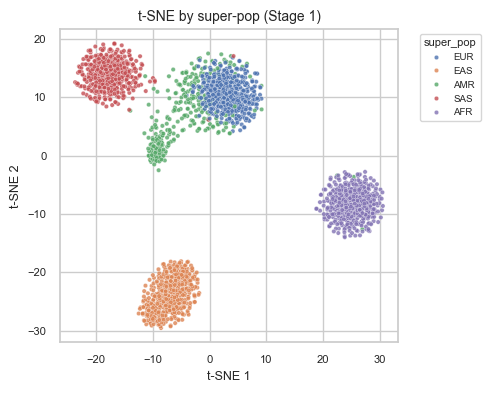

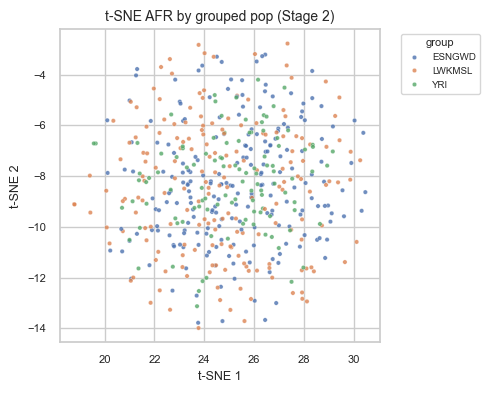

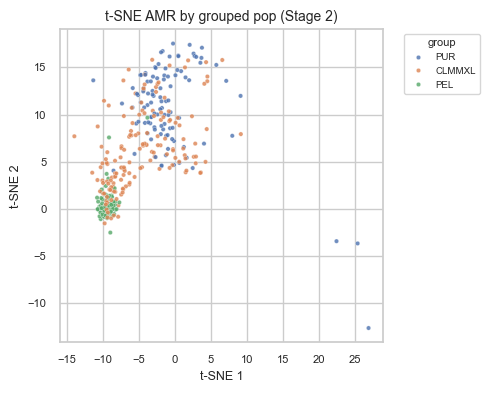

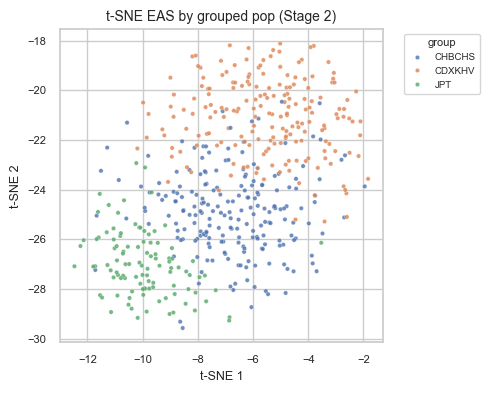

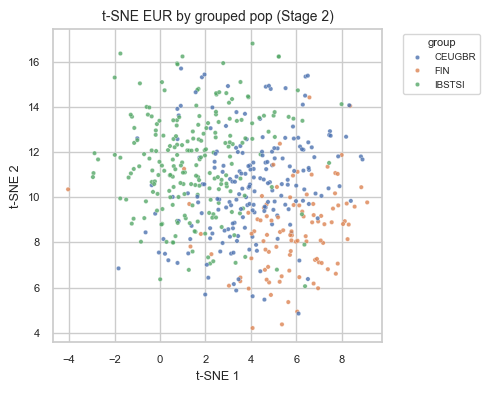

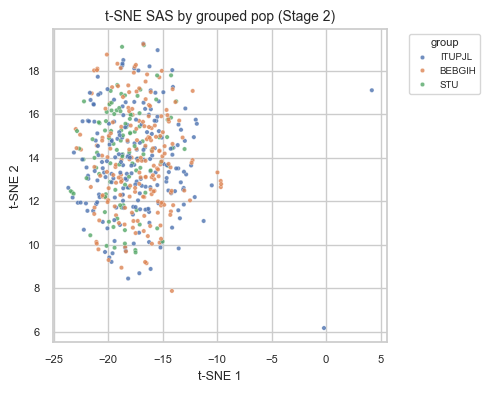

In [8]:
# t-SNE visualization for Stage 1 (super_pop) và Stage 2 theo từng châu lục

from sklearn.manifold import TSNE

# Tính t-SNE trên toàn bộ dữ liệu đã impute
tsne = TSNE(n_components=2, random_state=42, perplexity=30, learning_rate="auto", init="pca")
X_tsne = tsne.fit_transform(X_imputed)

tsne_df = pd.DataFrame({
    "tsne1": X_tsne[:, 0],
    "tsne2": X_tsne[:, 1],
    "super_pop": df["super_pop"].astype(str).values,
})

# Tạo nhãn gộp toàn cục cho Stage 2 (cùng logic group_map như khi train)
group_labels = []
for sp, p in zip(df["super_pop"], df["pop"]):
    gm = continent_group_maps.get(str(sp), {})
    group_labels.append(gm.get(str(p), str(p)))

tsne_df["group_label"] = group_labels

# Plot 1: toàn bộ mẫu tô màu theo super_pop (bài toán continent)
fig, ax = plt.subplots(figsize=(5, 4))
sns.scatterplot(data=tsne_df, x="tsne1", y="tsne2", hue="super_pop", s=10, alpha=0.8, ax=ax)
ax.set_title("t-SNE by super-pop (Stage 1)")
ax.set_xlabel("t-SNE 1")
ax.set_ylabel("t-SNE 2")
ax.legend(title="super_pop", fontsize=7, title_fontsize=8, bbox_to_anchor=(1.05, 1), loc="upper left")
fig.tight_layout()
plt.show()

# Plot 2+: với mỗi châu lục, chỉ vẽ các mẫu của châu lục đó và tô màu theo nhãn pop (nhãn gộp Stage 2)
for continent in sorted(tsne_df["super_pop"].unique()):
    sub_df = tsne_df[tsne_df["super_pop"] == continent].copy()
    if sub_df.empty:
        continue
    fig_c, ax_c = plt.subplots(figsize=(5, 4))
    sns.scatterplot(data=sub_df, x="tsne1", y="tsne2", hue="group_label", s=10, alpha=0.8, ax=ax_c)
    ax_c.set_title(f"t-SNE {continent} by grouped pop (Stage 2)")
    ax_c.set_xlabel("t-SNE 1")
    ax_c.set_ylabel("t-SNE 2")
    ax_c.legend(title="group", fontsize=7, title_fontsize=8, bbox_to_anchor=(1.05, 1), loc="upper left")
    fig_c.tight_layout()
    plt.show()

In [9]:
# Export LaTeX (Overleaf) tables with model metrics

import os
import pandas as pd

latex_dir = os.path.join("reports")
os.makedirs(latex_dir, exist_ok=True)

# Stage 1 summary table from stage1_metrics
stage1_rows = []
for model_name, m in stage1_metrics.items():
    stage1_rows.append({
        "Model": model_name,
        "Accuracy": m["accuracy"],
        "Macro-F1": m["macro_f1"],
        "Weighted-F1": m["weighted_f1"],
    })
stage1_df = pd.DataFrame(stage1_rows)

# Stage 2 summary table from stage2_metrics
stage2_df = pd.DataFrame(stage2_metrics)
stage2_df = stage2_df[["continent", "model", "accuracy", "macro_f1", "weighted_f1"]]
stage2_df = stage2_df.rename(columns={
    "continent": "Continent",
    "model": "Model",
    "accuracy": "Accuracy",
    "macro_f1": "Macro-F1",
    "weighted_f1": "Weighted-F1",
})

# Sắp xếp và ẩn tên châu lục ở hàng thứ 2 cho dễ nhìn
stage2_df = stage2_df.sort_values(["Continent", "Model"]).reset_index(drop=True)
cont_display = []
last_cont = None
for c in stage2_df["Continent"]:
    if c == last_cont:
        cont_display.append("")
    else:
        cont_display.append(c)
        last_cont = c
stage2_df["Continent"] = cont_display

latex_parts = []
latex_parts.append("% Stage 1: Continental classification metrics")
latex_parts.append(stage1_df.to_latex(index=False, float_format=lambda x: f"{x:.4f}", caption="Stage 1: Continental classification metrics", label="tab:stage1_metrics"))
latex_parts.append("")
latex_parts.append("% Stage 2: Grouped population metrics by continent")
latex_parts.append(stage2_df.to_latex(index=False, float_format=lambda x: f"{x:.4f}", caption="Stage 2: Grouped population metrics by continent", label="tab:stage2_metrics"))

latex_code = "\n\n".join(latex_parts)

out_path = os.path.join(latex_dir, "bga_model_results_tables.txt")
with open(out_path, "w", encoding="utf-8") as f:
    f.write(latex_code)

print("LaTeX tables written to:", out_path)

LaTeX tables written to: reports\bga_model_results_tables.txt


In [10]:
# Demo: upload hoặc chọn file mẫu và chạy dự đoán hai tầng với cả XGB và generative (từ model đã lưu)

import io
import pickle
from IPython.display import display

try:
    import ipywidgets as widgets
    _have_widgets = True
except ImportError:
    _have_widgets = False

DEFAULT_SAMPLE_PATH = "data/stratified_samples_10.csv"

# Load artifacts đã lưu từ đĩa
continental_artifacts_path = os.path.join(MODELS_DIR, "continental_artifacts.pkl")
pop_models_path = os.path.join(MODELS_DIR, "population_models_grouped.pkl")

with open(continental_artifacts_path, "rb") as f:
    continental_artifacts = pickle.load(f)

with open(pop_models_path, "rb") as f:
    population_models_saved = pickle.load(f)

imputer_demo = continental_artifacts["imputer"]
le_super_demo = continental_artifacts["label_encoder"]
xgb_cont_demo = continental_artifacts["xgb_model"]
gen_cont_demo = continental_artifacts["gen_model"]
feature_cols_demo = continental_artifacts.get("snp_names", feature_cols)

def _display_group_label(lbl):
    if isinstance(lbl, str):
        return lbl.replace("_", "")
    return lbl

def run_demo_from_df(df_demo):
    """Chuẩn hóa cột, chạy Stage 1 + Stage 2 (XGB + generative) và trả về DataFrame kết quả + độ đo."""
    # Xác định cột ID mẫu (nếu có)
    id_col = None
    if "sample" in df_demo.columns:
        id_col = "sample"
    else:
        first_col = df_demo.columns[0]
        if first_col not in feature_cols_demo + ["pop", "super_pop", "source"]:
            id_col = first_col
    sample_ids = (
        df_demo[id_col].astype(str).tolist()
        if id_col is not None
        else [f"sample_{i}" for i in range(len(df_demo))]
    )

    # Căn chỉnh cột SNP cho trùng với feature_cols đã dùng để train
    X_demo_df = df_demo.reindex(columns=feature_cols_demo, fill_value=np.nan)
    X_demo = X_demo_df.values
    X_demo_imp = imputer_demo.transform(X_demo)

    # Stage 1: dự đoán siêu quần thể (châu lục) bằng cả XGB và generative
    y_super_xgb_idx = xgb_cont_demo.predict(X_demo_imp)
    pred_super_xgb = le_super_demo.inverse_transform(y_super_xgb_idx)

    y_super_gen_idx = gen_cont_demo.predict(X_demo_imp)
    pred_super_gen = le_super_demo.inverse_transform(y_super_gen_idx)

    # Stage 2: với mỗi mẫu, chọn mô hình theo châu lục (theo XGB) và dự đoán nhãn quần thể bằng XGB + generative
    pred_group_xgb = []
    pred_group_gen = []
    for i, cont in enumerate(pred_super_xgb):
        if cont in population_models_saved:
            models_c = population_models_saved[cont]
            xgb_c = models_c["xgb_model"]
            gen_c = models_c["gen_model"]
            le_c = models_c["label_encoder"]
            y_pop_xgb_idx = xgb_c.predict(X_demo_imp[i : i + 1, :])
            y_pop_gen_idx = gen_c.predict(X_demo_imp[i : i + 1, :])
            y_pop_xgb = le_c.inverse_transform(y_pop_xgb_idx)[0]
            y_pop_gen = le_c.inverse_transform(y_pop_gen_idx)[0]
        else:
            y_pop_xgb = None
            y_pop_gen = None
        pred_group_xgb.append(y_pop_xgb)
        pred_group_gen.append(y_pop_gen)

    # True labels: super_pop và nhãn gộp (tính lại theo cùng group_map để cùng không gian nhãn)
    if "super_pop" in df_demo.columns and "pop" in df_demo.columns:
        true_super = df_demo["super_pop"].astype(str).tolist()
        true_group_raw = []
        for sp, p in zip(df_demo["super_pop"], df_demo["pop"]):
            if pd.isna(sp) or pd.isna(p):
                true_group_raw.append("")
            else:
                gm = continent_group_maps.get(str(sp), {})
                true_group_raw.append(gm.get(str(p), str(p)))
    else:
        true_super = [""] * len(df_demo)
        true_group_raw = [""] * len(df_demo)

    # Chuyển nhãn gộp sang dạng 6 chữ (bỏ gạch dưới) cho hiển thị
    true_group_disp = [_display_group_label(g) for g in true_group_raw]
    pred_group_xgb_disp = [_display_group_label(g) for g in pred_group_xgb]
    pred_group_gen_disp = [_display_group_label(g) for g in pred_group_gen]

    # Tính các độ đo trên tập demo
    metrics_demo = {}
    # Stage 1
    true_super_arr = np.array(true_super)
    pred_super_xgb_arr = np.array(pred_super_xgb)
    pred_super_gen_arr = np.array(pred_super_gen)
    mask_super = true_super_arr != ""
    if mask_super.any():
        metrics_demo["stage1_xgb_acc"] = float((true_super_arr[mask_super] == pred_super_xgb_arr[mask_super]).mean())
        metrics_demo["stage1_gen_acc"] = float((true_super_arr[mask_super] == pred_super_gen_arr[mask_super]).mean())
    else:
        metrics_demo["stage1_xgb_acc"] = None
        metrics_demo["stage1_gen_acc"] = None

    # Stage 2
    true_group_arr = np.array(true_group_raw, dtype=object)
    pred_group_xgb_arr = np.array(pred_group_xgb, dtype=object)
    pred_group_gen_arr = np.array(pred_group_gen, dtype=object)
    mask_group = np.array([bool(t) and (px is not None) for t, px in zip(true_group_arr, pred_group_xgb_arr)])
    if mask_group.any():
        metrics_demo["stage2_xgb_acc"] = float((true_group_arr[mask_group] == pred_group_xgb_arr[mask_group]).mean())
        metrics_demo["stage2_gen_acc"] = float((true_group_arr[mask_group] == pred_group_gen_arr[mask_group]).mean())
    else:
        metrics_demo["stage2_xgb_acc"] = None
        metrics_demo["stage2_gen_acc"] = None

    results_demo = pd.DataFrame({
        "sample_id": sample_ids,
        "true_super_pop": true_super,
        "true_pop": true_group_disp,
        "pred_super_pop_xgb": pred_super_xgb,
        "pred_super_pop_gen": pred_super_gen,
        "pred_group_xgb": pred_group_xgb_disp,
        "pred_group_gen": pred_group_gen_disp,
    })
    return results_demo, metrics_demo

if _have_widgets:
    upload = widgets.FileUpload(accept=".csv,.tsv,.txt", multiple=False)
    path_text = widgets.Text(
        value=DEFAULT_SAMPLE_PATH,
        description="Path:",
        layout=widgets.Layout(width="70%"),
)
    run_button = widgets.Button(description="Run demo", button_style="primary")
    out = widgets.Output()

    def _on_run_clicked(_):
        with out:
            out.clear_output()
            df_demo = None
            if upload.value:
                v = upload.value
                # ipywidgets>=7: dict; ipywidgets 8: tuple
                if isinstance(v, dict):
                    fname, fileinfo = next(iter(v.items()))
                    content = fileinfo.get("content")
                else:
                    fileinfo = v[0]
                    fname = fileinfo.get("name", "uploaded")
                    content = fileinfo.get("content")
                if content is None:
                    print("Uploaded file has no content, please try again.")
                    return
                df_demo = pd.read_csv(io.BytesIO(content))
                print("Using uploaded file:", fname, "shape:", df_demo.shape)
            else:
                path = path_text.value
                print("Reading sample data from:", path)
                df_demo = pd.read_csv(path)
            results_demo, metrics_demo = run_demo_from_df(df_demo)
            display(results_demo.head(10))
            print("\nDemo metrics (only rows with ground truth):")
            s1x = metrics_demo.get("stage1_xgb_acc")
            s1g = metrics_demo.get("stage1_gen_acc")
            s2x = metrics_demo.get("stage2_xgb_acc")
            s2g = metrics_demo.get("stage2_gen_acc")
            if s1x is not None:
                print(f"  Stage 1 XGB accuracy: {s1x:.4f}")
            if s1g is not None:
                print(f"  Stage 1 Generative accuracy: {s1g:.4f}")
            if s2x is not None:
                print(f"  Stage 2 XGB accuracy: {s2x:.4f}")
            if s2g is not None:
                print(f"  Stage 2 Generative accuracy: {s2g:.4f}")

    run_button.on_click(_on_run_clicked)

    display(
        widgets.VBox(
            [
                widgets.HTML("<b>Demo: upload CSV hoặc nhập đường dẫn file để dự đoán</b>"),
                widgets.HBox([widgets.Label("Upload:"), upload]),
                path_text,
                run_button,
                out,
            ]
)
)
else:
    print("ipywidgets chưa cài, dùng đường dẫn cố định.")
    path = DEFAULT_SAMPLE_PATH
    print("Reading sample data from:", path)
    df_demo = pd.read_csv(path)
    results_demo, metrics_demo = run_demo_from_df(df_demo)
    print(results_demo.head(10))
    print("\nDemo metrics (only rows with ground truth):")
    s1x = metrics_demo.get("stage1_xgb_acc")
    s1g = metrics_demo.get("stage1_gen_acc")
    s2x = metrics_demo.get("stage2_xgb_acc")
    s2g = metrics_demo.get("stage2_gen_acc")
    if s1x is not None:
        print(f"  Stage 1 XGB accuracy: {s1x:.4f}")
    if s1g is not None:
        print(f"  Stage 1 Generative accuracy: {s1g:.4f}")
    if s2x is not None:
        print(f"  Stage 2 XGB accuracy: {s2x:.4f}")
    if s2g is not None:
        print(f"  Stage 2 Generative accuracy: {s2g:.4f}")